In [1]:
# TODO
# Q: Should we choose thresh where balanced accuracy == accuracy, or where balanced accuracy is max?

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.utils import resample

### Read data

In [3]:
df = pd.read_csv('../../../data/allstate-main.csv')

In [4]:
df.head()

territory gender  birthdate  ypc  current_premium  indicated_premium  \
0        601      M  10/5/1947    0           863.97             830.58   
1        601      F   7/6/1953    0           828.63             611.14   
2        601      M  4/18/1956    0          1000.59             593.99   
3        601      F  8/16/1956    0           700.42             547.95   
4        601      F  1/23/1957    0           505.92             448.33   

   selected_premium  underlying_premium  fixed_expenses  \
0            862.57              673.06          175.98   
1            826.43              612.75          175.98   
2            996.60              858.20          175.98   
3            697.84              571.49          180.48   
4            504.56              333.71          152.08   

   underlying_total_premium  ...  population perc_nonwhite majority_minority  \
0                    849.04  ...       24233     58.758717              True   
1                    788.73  ...       24233     58.758717              True   
2                   1034.18  ...       24233     58.758717              True   
3                    751.97  ...       24233     58.758717              True   
4                    485.79  ...       24233     58.758717              True   

         age  change_in_premium age_  risk_group  risk_group_0  risk_group_1  \
0  73.107593              -1.40   73           0             1             0   
1  67.355250              -2.20   67           0             1             0   
2  64.570799              -3.99   65           0             1             0   
3  64.242250              -2.58   64           0             1             0   
4  63.804185              -1.36   64           0             1             0   

   perc_change_in_premium  
0               -0.162043  
1               -0.265498  
2               -0.398765  
3               -0.368350  
4               -0.268817  

[5 rows x 28 columns]

In [5]:
df.shape

(92786, 28)

### Features engineering

In [6]:
# Features naming
# propercase for orig variable name
# lowercase for variable classes

#### Convert premium to int

In [7]:
df['current_premium_int'] = df['current_premium'].round().astype(int)

#### Convert age into categorical variables

In [8]:
df['age_group'] = pd.cut(df['age_'], bins=[20,40,60,80,100,150], labels=['young', 'middle-aged', 'senior',
                                                                        'retired', 'old'])

In [9]:
df = pd.concat([df, pd.get_dummies(df['age_group'], drop_first=False)], axis=1)

#### Add male, female

In [10]:
df = pd.concat([df, pd.get_dummies(df['gender'], drop_first=False)], axis=1)
df.rename(columns={'F':'female', 'M':'male'}, inplace=True)

#### Add ypc dummies

In [11]:
df = pd.concat([df, pd.get_dummies(df['ypc'], prefix='ypc')], axis=1)

#### Add minority

In [12]:
df['majority_minority'] = df['majority_minority'] * 1

In [13]:
df.rename(columns={'majority_minority':'minority'}, inplace=True)

In [14]:
pd.set_option('display.max_columns', 100)

In [15]:
df.head()

territory gender  birthdate  ypc  current_premium  indicated_premium  \
0        601      M  10/5/1947    0           863.97             830.58   
1        601      F   7/6/1953    0           828.63             611.14   
2        601      M  4/18/1956    0          1000.59             593.99   
3        601      F  8/16/1956    0           700.42             547.95   
4        601      F  1/23/1957    0           505.92             448.33   

   selected_premium  underlying_premium  fixed_expenses  \
0            862.57              673.06          175.98   
1            826.43              612.75          175.98   
2            996.60              858.20          175.98   
3            697.84              571.49          180.48   
4            504.56              333.71          152.08   

   underlying_total_premium  cgr_factor  cgr   county  county_code  zipcode  \
0                    849.04        1.02  ZHK  CHARLES            8    20601   
1                    788.73        1.06  6NS  CHARLES            8    20601   
2                   1034.18        0.96  Z2D  CHARLES            8    20601   
3                    751.97        0.91  D7G  CHARLES            8    20601   
4                    485.79        1.06  3YN  CHARLES            8    20601   

      town  area  GEO.id2  population  perc_nonwhite  minority        age  \
0  WALDORF   210    20601       24233      58.758717         1  73.107593   
1  WALDORF   210    20601       24233      58.758717         1  67.355250   
2  WALDORF   210    20601       24233      58.758717         1  64.570799   
3  WALDORF   210    20601       24233      58.758717         1  64.242250   
4  WALDORF   210    20601       24233      58.758717         1  63.804185   

   change_in_premium  age_  risk_group  risk_group_0  risk_group_1  \
0              -1.40    73           0             1             0   
1              -2.20    67           0             1             0   
2              -3.99    65           0             1             0   
3              -2.58    64           0             1             0   
4              -1.36    64           0             1             0   

   perc_change_in_premium  current_premium_int age_group  young  middle-aged  \
0               -0.162043                  864    senior      0            0   
1               -0.265498                  829    senior      0            0   
2               -0.398765                 1001    senior      0            0   
3               -0.368350                  700    senior      0            0   
4               -0.268817                  506    senior      0            0   

   senior  retired  old  female  male  ypc_0  ypc_1  ypc_2  ypc_3  ypc_4  \
0       1        0    0       0     1      1      0      0      0      0   
1       1        0    0       1     0      1      0      0      0      0   
2       1        0    0       0     1      1      0      0      0      0   
3       1        0    0       1     0      1      0      0      0      0   
4       1        0    0       1     0      1      0      0      0      0   

   ypc_5  
0      0  
1      0  
2      0  
3      0  
4      0

### Create modelling dataset

In [16]:
dataset = df[['current_premium', 'risk_group', 'young', 'middle-aged', 'senior', 'retired', 'old', 'female', 'male', 'ypc_0', 'ypc_1', 'ypc_2', 'ypc_3', 'ypc_4', 'ypc_5', 'minority']].copy()



### Calculate baseline accuracy

In [17]:
# TODO: move common funcs to utils and import from there

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, accuracy_score, \
precision_score, recall_score
from sklearn.metrics import balanced_accuracy_score

In [19]:
def logreg(X, y, test_size=0.3, plots=True, metrics=True):
    
    def plot_pr_curve(labels, prediction_scores):
        pr, rc, _ = precision_recall_curve(labels, prediction_scores, pos_label=0)

        plt.plot(rc, pr, label='Logistic model')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.grid('on')
        plt.axis('square')
        plt.legend()
        plt.tight_layout()
    
    def plot_roc(labels, prediction_scores):
        # pos_label should match favorable_label from aif360
        fpr, tpr, _ = roc_curve(labels, prediction_scores, pos_label=0)
        auc = roc_auc_score(labels, prediction_scores)
        legend_string = 'AUC = {:0.3f}'.format(auc)

        plt.plot([0,1],[0,1],'--', color='gray', label='Chance')
        plt.plot(fpr, tpr, label=legend_string)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.grid('on')
        plt.axis('square')
        plt.legend()
        plt.tight_layout()
        
    def confusion_matrix(labels, prediction_scores):
        cm = sk_confusion_matrix(labels, prediction_scores)
        cm = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
        cm.columns.name = 'Predicted label'
        cm.index.name = 'True label'
        error_rate = (prediction_scores != labels).mean()
        print('The error rate is: %.2f' % error_rate)
        return cm
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    logreg = LogisticRegression().fit(X_train, y_train)
    y_preds_proba = logreg.predict_proba(X_test)[:,1]
    
    # use this to split classifications into 0s and 1s
    thresh = np.mean(y_test)
    y_preds = np.where(y_preds_proba > thresh, 1, 0)
    
    # plot roc and pr curves
    if plots:
        plot_roc(y_test, y_preds_proba)
        plt.show()
        plot_pr_curve(y_test, y_preds_proba)
        plt.show()
    
    # report accuracy metrics
    if metrics:
        print("The accuracy score of the model is %s" % (accuracy_score(y_test, y_preds)))
        print("The balanced accuracy score of the model is %s" % (balanced_accuracy_score(y_test, y_preds)))

        # tn, fp, fn, tp
        print(confusion_matrix(y_test, np.where(y_preds_proba > thresh, 1, 0).ravel()))

        print("Precision: %s" % (precision_score(y_test, y_preds)))
        print("Recall: %s" % (recall_score(y_test, y_preds)))
        
    return logreg

In [20]:
X = dataset[['current_premium', 'middle-aged', 'male', 'ypc_1', 'minority']].values

In [21]:
y = dataset['risk_group'].values

In [22]:
test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
model = logreg(X, y, test_size=test_size, plots=False, metrics=False)

In [23]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
ac_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 1, num_thresh)

for idx, class_thresh in enumerate(class_thresh_arr):
#     print(class_thresh)
    y_preds_proba = model.predict_proba(X_test)[:,1]
    y_preds = np.where(y_preds_proba > class_thresh, 1, 0)
    
    ac_arr[idx] = accuracy_score(y_test, y_preds)
    ba_arr[idx] = balanced_accuracy_score(y_test, y_preds)

# best threshold is where the type of accuracy is max
best_ind_ba = np.where(ba_arr == np.max(ba_arr))[0][0]
best_ind_ac = np.where(ac_arr == np.max(ac_arr))[0][0]

best_class_thresh_ba = class_thresh_arr[best_ind_ba]
best_class_thresh_ac = class_thresh_arr[best_ind_ac]

print("Best balanced accuracy = %.4f" % np.max(ba_arr))
print("Optimal classification threshold = %.4f" % best_class_thresh_ba)

print("Best accuracy = %.4f" % np.max(ac_arr))
print("Optimal classification threshold = %.4f" % best_class_thresh_ac)

Best balanced accuracy = 0.9596
Optimal classification threshold = 0.0300
Best accuracy = 0.9807
Optimal classification threshold = 1.0000


In [24]:
sns.set()

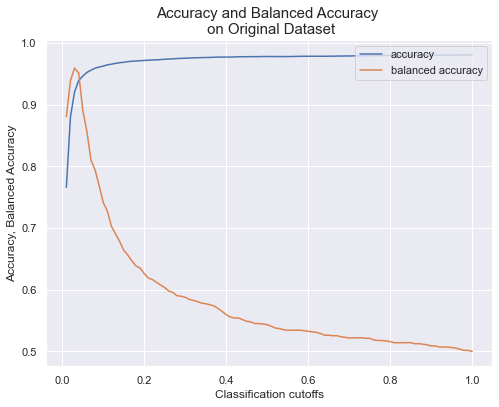

In [25]:
plt.figure(figsize=(8,6))

plt.plot(class_thresh_arr, ac_arr, label='accuracy')
plt.plot(class_thresh_arr, ba_arr, label='balanced accuracy')

plt.xlabel('Classification cutoffs')
plt.ylabel('Accuracy, Balanced Accuracy')

plt.legend(loc='upper right')
plt.title('Accuracy and Balanced Accuracy \n on Original Dataset', size=15)
plt.show()

### Resampling

#### Upsample risk group=1

In [26]:
dataset.shape

(92786, 16)

In [27]:
sns.reset_orig()

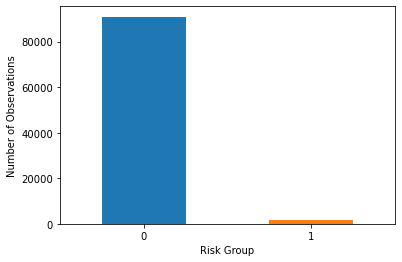

In [28]:
dataset['risk_group'].value_counts().plot(kind='bar', color=['tab:blue', 'tab:orange'])
plt.xticks(rotation=0)
plt.xlabel('Risk Group')
plt.ylabel('Number of Observations')
plt.show()

In [29]:
dataset_riskgrp0 = dataset[dataset['risk_group'] == 0].copy()
dataset_riskgrp1 = dataset[dataset['risk_group'] == 1].copy()

samples = dataset_riskgrp0.shape[0]

dataset_riskgrp1_rs = resample(dataset_riskgrp1, replace=True, n_samples=samples, random_state=786)

dataset = dataset_riskgrp0.append(dataset_riskgrp1_rs)

In [30]:
dataset['risk_group'].value_counts()

1    90951
0    90951
Name: risk_group, dtype: int64

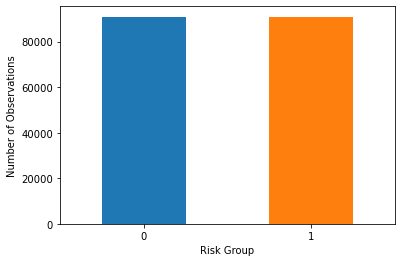

In [31]:
dataset['risk_group'].value_counts().plot(kind='bar', color=['tab:blue', 'tab:orange'])
plt.xticks(ticks=[0,1], labels=('0', '1'), rotation=0)
plt.xlabel('Risk Group')
plt.ylabel('Number of Observations')
plt.show()

In [32]:
# dataset.to_csv('../../../data/modelling-dataset.csv', index=None)

### Accuracy vs Balanced accuracy

In [33]:
X = dataset[['current_premium', 'middle-aged', 'male', 'ypc_1', 'minority']].values

In [34]:
y = dataset['risk_group'].values

In [35]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
ac_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 1, num_thresh)
model = logreg(X, y, plots=False, metrics=False)

for idx, class_thresh in enumerate(class_thresh_arr):
#     print(class_thresh)
    y_preds_proba = model.predict_proba(X_test)[:,1]
    y_preds = np.where(y_preds_proba > class_thresh, 1, 0)
    
    ac_arr[idx] = accuracy_score(y_test, y_preds)
    ba_arr[idx] = balanced_accuracy_score(y_test, y_preds)

In [36]:
# best threshold is where the accuracy is max
best_ind_ba = np.where(ba_arr == np.max(ba_arr))[0][0]
best_ind_ac = np.where(ac_arr == np.max(ac_arr))[0][0]

best_class_thresh_ba = class_thresh_arr[best_ind_ba]
best_class_thresh_ac = class_thresh_arr[best_ind_ac]

print("Best balanced accuracy = %.4f" % np.max(ba_arr))
print("Optimal classification threshold = %.4f" % best_class_thresh_ba)

print("Best accuracy = %.4f" % np.max(ac_arr))
print("Optimal classification threshold = %.4f" % best_class_thresh_ac)

print("Mean balanced accuracy = %.4f" % np.mean(ba_arr))
print("Mean accuracy = %.4f" % np.mean(ac_arr))

Best balanced accuracy = 0.9652
Optimal classification threshold = 0.5800
Best accuracy = 0.9807
Optimal classification threshold = 1.0000
Mean balanced accuracy = 0.9018
Mean accuracy = 0.9025


In [37]:
sns.set()

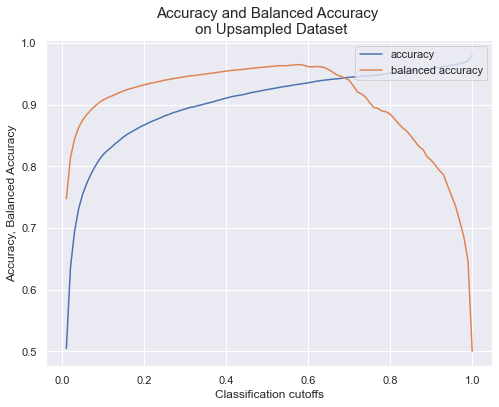

In [38]:
plt.figure(figsize=(8,6))

plt.plot(class_thresh_arr, ac_arr, label='accuracy')
plt.plot(class_thresh_arr, ba_arr, label='balanced accuracy')

plt.xlabel('Classification cutoffs')
plt.ylabel('Accuracy, Balanced Accuracy')

plt.legend(loc='upper right')
plt.title('Accuracy and Balanced Accuracy \n on Upsampled Dataset', size=15)
plt.show()